In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.signal import welch

Cargamos los datos:

In [3]:
eeg1 = pd.read_csv("participantes/eeg_pp_6.csv")

features1 = pd.read_csv("participantes/eeg_features_6.csv")

In [3]:
eeg1.head()

,latency,fp1,fp2,f7,f3,fz,f4,f8,t7,c3,cz,c4,t8,p7,p3,pz,p4,p8,o1,o2
0,0.00070,0.309389,0.290336,5.638164,-0.818729,-0.504169,1.487456,2.887529,1.213480,-4.029498,-0.672450,1.612597,-0.824774,2.975999,1.022574,-0.833127,-1.695004,-3.942237,0.404906,-2.895844
1,0.00461,-4.268272,-8.162009,6.429711,-1.985342,-4.760065,-6.749328,-13.431440,4.083466,0.646092,0.140566,-5.412485,-6.116808,4.435639,-2.334405,3.561102,-0.777974,17.173880,23.763550,16.555790
2,0.00851,-3.608200,-6.728729,5.083628,-0.688027,-4.598368,-11.715440,-22.266350,6.175829,5.920442,3.107298,-11.042280,-6.313046,7.216393,-5.984515,6.448220,5.045274,23.580150,32.425360,21.466020
3,0.01242,-0.990094,-1.666949,2.061801,0.293902,-2.498589,-11.335760,-20.539050,7.662349,6.987745,5.407189,-10.873840,-3.666028,8.870134,-7.269728,6.621826,9.996819,18.417150,27.481300,14.233560
4,0.01633,-1.883662,-2.923725,0.480767,-1.869973,-3.573886,-9.660854,-13.718060,5.956882,4.247873,3.497454,-6.887740,-3.536912,7.348356,-3.639939,5.201068,7.014519,15.360610,21.289010,10.010260


In [4]:
len(eeg1), len(features1)

(95232, 2330)

In [5]:
features1.isnull().sum()

epoch                   0
window                  0
n_samples               0
Start_w                 0
End_w                   0
                       ..
ch19-LowGamma-Kurt      0
ch19-LowGamma-RelPow    0
ch19-LowGamma-HjAct     0
ch19-LowGamma-HjMob     0
ch19-LowGamma-HjComp    0
Length: 1261, dtype: int64

In [6]:
features1['Trust'].value_counts(dropna=False)

Trust
5.0    1000
4.0     400
NaN     330
1.0     300
2.0     150
3.0     150
Name: count, dtype: int64

In [4]:
features1 = features1.dropna(subset=["Trust", "Binary_Trust"]).reset_index(drop=True)


Para llevar a cabo el análisis de la señal, hay que incorporar la columna "epoch" del dataset "features" al dataset con las señales EEG en crudo, para, más tarde, llevar a cabo la partición de los datos adecuada, se unirá esta columna según los valores de "Start_w" y "End_w" y considerando el valor de latencia de las señales. De esta manera, se obtendrá un dataset con las señales EEG en crudo, la epoch a la que pertenece, la latencia y el valor de Trust y Binary_Trust.

In [ ]:
def assign_epochs(eeg1, features1):
    eeg1 = eeg1.copy()
    eeg1["epoch"] = np.nan
    eeg1["Trust"] = np.nan
    eeg1["Binary_Trust"] = np.nan
    
    for _, row in features1.iterrows():
        mask = (eeg1["latency"] >= row["Start_w"]) & (eeg1["latency"] <= row["End_w"])
        eeg1.loc[mask, "epoch"] = row["epoch"]
        eeg1.loc[mask, "Trust"] = row["Trust"]
        eeg1.loc[mask, "Binary_Trust"] = row["Binary_Trust"]
    
    return eeg1

# Asignar etiquetas
eeg1 = assign_epochs(eeg1, features1)

# Ver cuántos valores se quedaron sin epoch
print("Sin epoch:", eeg1["epoch"].isna().sum(), "de un total de", len(eeg1))

# Ver distribución de etiquetas
print("\nDistribución Binary_Trust:")
print(eeg1["Binary_Trust"].value_counts(dropna=False))

print("\nDistribución Trust:")
print(eeg1["Trust"].value_counts(dropna=False))


C:\Users\crist\AppData\Local\Temp\ipykernel_25540\1576416167.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'high_trust' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  eeg1.loc[mask, "Binary_Trust"] = row["Binary_Trust"]


Sin epoch: 29746 de un total de 95232

Distribución Binary_Trust:
Binary_Trust
high_trust    45693
NaN           29746
low_trust     19793
Name: count, dtype: int64

Distribución Trust:
Trust
5.0    34192
NaN    29746
4.0    11501
1.0     9134
2.0     5705
3.0     4954
Name: count, dtype: int64


Podemos observar que nos queda un alto % de valores nulos, esto se debe a que el primer start_w comienza más tarde que el primer valor de latencia, y lo mismo para el último valor de end_w, termina antes que el último valor de latencia. Estos nulos pueden corresponder con valores erróneos en la colocación inicial del casco o al momento de acabar el experimento, por lo que optamos por eliminarlos.

In [ ]:
# Eliminar filas donde alguna de las columnas clave es NaN
eeg1 = eeg1.dropna(subset=['epoch', 'Trust', 'Binary_Trust']).reset_index(drop=True)

#  Ver cuántos valores se quedaron sin epoch
print("Sin epoch:", eeg1["epoch"].isna().sum(), "de un total de", len(eeg1))

# Ver distribución de etiquetas
print("\nDistribución Binary_Trust:")
print(eeg1["Binary_Trust"].value_counts(dropna=False))

print("\nDistribución Trust:")
print(eeg1["Trust"].value_counts(dropna=False))


Sin epoch: 0 de un total de 65486

Distribución Binary_Trust:
Binary_Trust
high_trust    45693
low_trust     19793
Name: count, dtype: int64

Distribución Trust:
Trust
5.0    34192
4.0    11501
1.0     9134
2.0     5705
3.0     4954
Name: count, dtype: int64


C:\Users\crist\AppData\Local\Temp\ipykernel_25540\3394219416.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=eeg1['Binary_Trust'], palette='coolwarm')
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


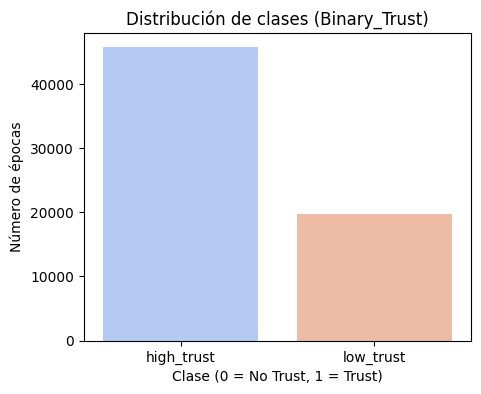

Distribución porcentual:
 Binary_Trust
high_trust    0.697752
low_trust     0.302248
Name: proportion, dtype: float64


In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x=eeg1['Binary_Trust'], palette='coolwarm')
plt.title("Distribución de clases (Binary_Trust)")
plt.xlabel("Clase (0 = No Trust, 1 = Trust)")
plt.ylabel("Número de épocas")
plt.show()

print("Distribución porcentual:\n", eeg1['Binary_Trust'].value_counts(normalize=True))

### Almacén de resultados

In [201]:
import os
def save_f1_history(clf, architecture, participant):
    f1_curve = clf.history_[:, 'f1_macro']
    df_new = pd.DataFrame({
        'epoch': range(1, len(f1_curve)+1),
        'f1': f1_curve,
        'architecture': architecture,
        'participant': participant
    })

    filename = "historial_f1_global.csv"

    if os.path.exists(filename):
        df_old = pd.read_csv(filename)
        df_final = pd.concat([df_old, df_new], ignore_index=True)
    else:
        df_final = df_new

    df_final.to_csv(filename, index=False)
    print(f"Guardado en {filename}")


## Red Neuronal EEGNet

In [8]:
from braindecode import EEGClassifier
from braindecode.models import EEGNet
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
from skorch.helper import predefined_split

In [13]:
fs = 1 / (eeg1['latency'].iloc[1] - eeg1['latency'].iloc[0])
print("Frecuencia de muestreo (Hz):", fs)

Frecuencia de muestreo (Hz): 255.7502439024826


### Focal Loss

In [26]:
import torch.nn as nn
import torch.nn.functional as F
# Es una función de pérdida que nos sirve para clases desbalanceadas
# gamma controla cuánto penaliza la pérdida

class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = (1 - pt) ** self.gamma * CE_loss
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss


### Trial Wise

Dividimos los datos de manera que no queden muestras mezcladas en los distintos conjuntos de entrenamiento, validación y test

In [ ]:
# Identificar todos los trials (epochs)
epochs = eeg1['epoch'].dropna().unique()

# Asociar cada trial a su etiqueta de confianza binaria
binary_trust_in_epoch = eeg1.groupby('epoch')['Binary_Trust'].first()

# Dividir trials en train, test y validación 
epochs_train, epochs_test = train_test_split(
    epochs,
    test_size=0.2,
    stratify=binary_trust_in_epoch.loc[epochs].values,
    random_state=42
)

# Dentro de train, split train/valid
epochs_train, epochs_valid = train_test_split(
    epochs_train,
    test_size=0.2,  
    stratify=binary_trust_in_epoch[epochs_train],
    random_state=42
)

df_train = eeg1[eeg1['epoch'].isin(epochs_train)].reset_index(drop=True)
df_valid = eeg1[eeg1['epoch'].isin(epochs_valid)].reset_index(drop=True)
df_test  = eeg1[eeg1['epoch'].isin(epochs_test)].reset_index(drop=True)

def make_trial_windows(df, window_size, stride):
    trials = df['epoch'].unique()
    X_list, y_list = [], []

    for trial in trials:
        trial_df = df[df['epoch']==trial].drop(columns=['latency','Trust','Binary_Trust','epoch'], errors='ignore')
        trial_signals = trial_df.values  
        label = df[df['epoch']==trial]['Binary_Trust'].iloc[0]
        label_bin = 0 if label=='low_trust' else 1

        # Extraer ventanas con stride
        for start in range(0, trial_signals.shape[0] - window_size + 1, stride):
            window = trial_signals[start:start+window_size, :]
            X_list.append(window.T)  
            y_list.append(label_bin)

    X_tensor = torch.tensor(X_list, dtype=torch.float32)
    y_tensor = torch.tensor(y_list, dtype=torch.long)

    return X_tensor, y_tensor

X_train_t, y_train_t = make_trial_windows(df_train, window_size=256, stride=32)
X_valid_t, y_valid_t = make_trial_windows(df_valid, window_size=256, stride=32)
X_test_t,  y_test_t  = make_trial_windows(df_test,  window_size=256, stride=32)

print(X_train_t.shape, y_train_t.shape)




torch.Size([523, 19, 256]) torch.Size([523])


### Selección de características

#### Métodos de filtro

In [ ]:
# === 2. Selección de canales (ANOVA) ===
from sklearn.feature_selection import f_classif

# Convertimos a numpy y aplanamos por tiempo para tener una feature por canal
X_train_mean = X_train_t.mean(dim=2).numpy()
y_np = y_train_t.numpy()

# Calculamos F y p-values
F_values, pvals = f_classif(X_train_mean, y_np)

# Escogemos los canales con p<0.05 (significativos)
k = 10  
selected_channels = np.argsort(F_values)[-k:]  
print("Canales seleccionados:", selected_channels)


# Filtramos los tensores
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]

print("Nueva forma de X_train:", X_train_t.shape)


Canales seleccionados: [ 4 17 18 16  8  7 10  2 11  6]
Nueva forma de X_train: torch.Size([523, 10, 256])


In [ ]:
from sklearn.feature_selection import mutual_info_classif

X_train_mean = X_train_t.mean(dim=2).numpy()
y_np = y_train_t.numpy()

# Mutual information
mi = mutual_info_classif(X_train_mean, y_np, random_state=42)
selected_channels = np.argsort(mi)[-10:]  

print("Canales seleccionados (MI):", selected_channels)

# Filtra los tensores
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]
print("Nueva forma de X_train:", X_train_t.shape)

Canales seleccionados (MI): [ 9  5  0 17 11 18 15  1  7  6]
Nueva forma de X_train: torch.Size([523, 10, 256])


#### Método híbrido (filter+wrapper)

In [176]:
from sklearn.feature_selection import mutual_info_classif, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

X_mean = X_train_t.numpy().mean(axis=2)
mi = mutual_info_classif(X_mean, y_train_t.numpy(), random_state=42)
top_k = min(14, X_mean.shape[1])
top_channels = np.argsort(mi)[-top_k:]
X_filtered = X_mean[:, top_channels]

wrapper = SequentialFeatureSelector(
        LogisticRegression(max_iter=1000),
        n_features_to_select=min(10, top_k),
        direction='forward',
        n_jobs=-1
    )
wrapper.fit(X_filtered, y_train_t.numpy())
selected_channels = top_channels[wrapper.get_support()]
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]
print("Canales finales (híbrido):", selected_channels)


Canales finales (híbrido): [13  2 16  9  0 17 11 15  1  7]


### Normalización de los datos

In [31]:
mean = X_train_t.mean(dim=(0,2), keepdim=True) 
std  = X_train_t.std(dim=(0,2), keepdim=True)
X_train_t = (X_train_t - mean) / (std + 1e-8)
X_valid_t = (X_valid_t - mean) / (std + 1e-8)
X_test_t  = (X_test_t - mean) / (std + 1e-8)


In [17]:
overlap = set(epochs_train).intersection(set(epochs_test))
print("Épocas repetidas en train y test:", overlap)

Épocas repetidas en train y test: set()


In [18]:
print("Train windows:", X_train_t.shape[0])
print("Valid windows:", X_valid_t.shape[0])
print("Test windows:",  X_test_t.shape[0])


Train windows: 523
Valid windows: 162
Test windows: 171


### Oversampling

In [ ]:
# Convertir etiquetas a numpy 
y_np = y_train_t.cpu().numpy() if torch.is_tensor(y_train_t) else y_train_t

# Contar ejemplos por clase
counts = np.bincount(y_np)
majority_class = np.argmax(counts)
minority_class = 1 - majority_class

# Índices de cada clase
idx_majority = np.where(y_np == majority_class)[0]
idx_minority = np.where(y_np == minority_class)[0]

# Oversampling: replicar aleatoriamente la minoritaria hasta igualar
idx_minority_upsampled = np.random.choice(idx_minority, size=len(idx_majority), replace=True)

# Combinar y mezclar
indices_balanced = np.concatenate([idx_majority, idx_minority_upsampled])
np.random.shuffle(indices_balanced)

# Crear los nuevos conjuntos
X_train_bal = X_train_t[indices_balanced]
y_train_bal = y_train_t[indices_balanced]

print("Nuevo tamaño:", len(y_train_bal))
print("Distribución balanceada:", torch.bincount(y_train_bal))


Nuevo tamaño: 758
Distribución balanceada: tensor([379, 379])


### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# Asegurar que los datos están en formato (n_samples, n_features)
X_np = X_train_t.cpu().numpy().reshape(X_train_t.shape[0], -1)
y_np = y_train_t.cpu().numpy()

# Aplicar SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_res, y_res = smote.fit_resample(X_np, y_np)

# Volver a tensores con la misma forma original
X_train_bal = torch.tensor(X_res, dtype=torch.float32).reshape(-1, *X_train_t.shape[1:])
y_train_bal = torch.tensor(y_res, dtype=torch.long)

print("Nuevo tamaño:", len(y_train_bal))
print("Distribución balanceada:", torch.bincount(y_train_bal))


Nuevo tamaño: 758
Distribución balanceada: tensor([379, 379])


### Modelo y entrenamiento

#### Creación del modelo

In [ ]:
chans = 19     
nb_classes = 2   

model = EEGNet(
    n_chans= chans,
    n_outputs= nb_classes,
    input_window_seconds= 1,
    n_times = 256,
    drop_prob=0.5,
    F1=8,F2=16,
)

In [40]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# criterion = FocalLoss(alpha = 0.6, gamma=1.5, reduction='mean')

#### Entrenamiento del modelo

In [ ]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False)

early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=0.001,
    lower_is_better=True,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-3,
    optimizer__lr=1e-4,
    batch_size=64,
    callbacks=[ 
               f1_macro],
    max_epochs=40,
    device='cpu',
)


In [42]:
# clf.fit(X_train_t, y_train_t)
clf.fit(X_train_bal, y_train_bal)

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.4547        0.6944       0.4568        0.6977  0.8713
      2      0.4605        0.6820       0.4630        0.6978  0.9825
      3      0.4290        0.6702       0.4321        0.6976  2.6544
      4      0.4390        0.6463       0.4444        0.6974  2.8627
      5      0.4299        0.6574       0.4321        0.6969  3.0059
      6      0.4496        0.6490       0.4506        0.6963  4.3877
      7      0.4684        0.6195       0.4691        0.6953  0.5890
      8      0.4560        0.6195       0.4568        0.6942  0.5435
      9      0.4506        0.6109       0.4506        0.6937  0.6146
     10      0.4625        0.6155       0.4630        0.6931  0.5831
     11      0.4743        0.6028       0.4753        0.6928  0.5721
     12      0.4861        0.5925       0.4877        0.6928  0.5696
     13      0.4853        0.5854 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNet (EEGNet)                                              [1, 19, 256]              [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                                 [1, 19, 256]              [1, 19, 256, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2                                [1, 19, 256, 1]           [1, 1, 19, 256]           --                        --
  ├─Conv2d (conv_temporal): 1-3                                [1, 1, 19, 256]           [1, 8, 19, 257]           512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                          [1, 8, 19, 257]           [1, 8, 19, 257]           16                        --
  ├─ParametrizedConv2dWithConstraint (conv_spatial): 1-5       [1, 8, 19, 257]           [1, 16, 1, 257]           --                        [19, 1]
  │    └─ModuleDict (parametrizations): 2-1                    --                        --                        --                        --
  │    │    └─ParametrizationList (weight): 3-1                --                        [16, 1, 19, 1]            304                       --
  ├─BatchNorm2d (bnorm_1): 1-6                                 [1, 16, 1, 257]           [1, 16, 1, 257]           32                        --
  ├─ELU (elu_1): 1-7                                           [1, 16, 1, 257]           [1, 16, 1, 257]           --                        --
  ├─AvgPool2d (pool_1): 1-8                                    [1, 16, 1, 257]           [1, 16, 1, 64]            --                        [1, 4]
  ├─Dropout (drop_1): 1-9                                      [1, 16, 1, 64]            [1, 16, 1, 64]            --                        --
  ├─Conv2d (conv_separable_depth): 1-10                        [1, 16, 1, 64]            [1, 16, 1, 65]            256                       [1, 16]
  ├─Conv2d (conv_separable_point): 1-11                        [1, 16, 1, 65]            [1, 16, 1, 65]            256                       [1, 1]
  ├─BatchNorm2d (bnorm_2): 1-12                                [1, 16, 1, 65]            [1, 16, 1, 65]            32                        --
  ├─ELU (elu_2): 1-13                                          [1, 16, 1, 65]            [1, 16, 1, 65]            --                        --
  ├─AvgPool2d (pool_2): 1-14                                   [1, 16, 1, 65]            [1, 16, 1, 8]             --                        [1, 8]
  ├─Dropout (drop_2): 1-15                                     [1, 16, 1, 8]             [1, 16, 1, 8]             --                        --
  ├─Sequential (final_layer): 1-16                             [1, 16, 1, 8]             [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-2                         [1, 16, 1, 8]             [1, 2, 1, 1]              258                       [1, 8]
  │    └─Rearrange (permute_back): 2-3                         [1, 2, 1, 1]              [1, 2, 1, 1]              --                        --
  │    └─SqueezeFinalOutput (squeeze): 2-4                     [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-2                         [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  ==========================================================================================================

#### Test

In [ ]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas 
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[ 16  20]
 [102  33]]
              precision    recall  f1-score   support

           0       0.14      0.44      0.21        36
           1       0.62      0.24      0.35       135

    accuracy                           0.29       171
   macro avg       0.38      0.34      0.28       171
weighted avg       0.52      0.29      0.32       171



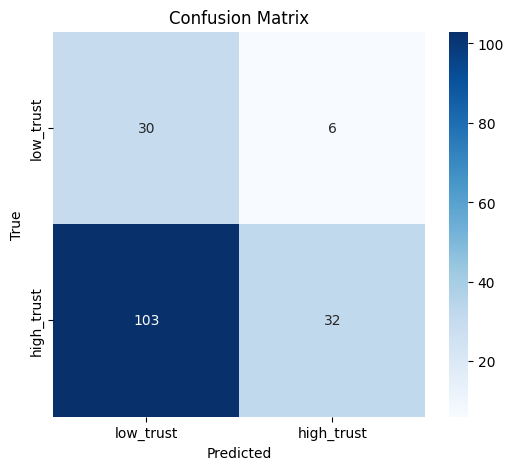

In [ ]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Nombres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1]  
y_true = y_test_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.321


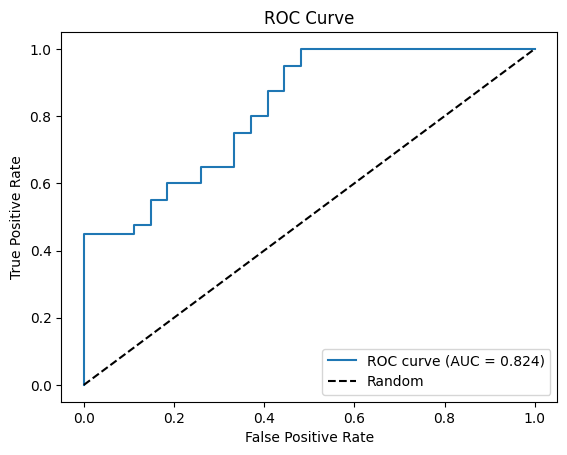

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [202]:
save_f1_history(
    clf=clf,
    architecture="EEGNet",
    participant="P6"
)

Guardado en historial_f1_global.csv


### RED EEGNeX

In [46]:
from braindecode.models import EEGNeX

In [ ]:
chans = 19      
nb_classes = 2   

model = EEGNeX(
    n_chans= chans,
    n_outputs= nb_classes,
    input_window_seconds= 1,
    n_times = 256,
    drop_prob=0.5,
)

In [48]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# criterion = FocalLoss(alpha = 0.4, gamma=1.5, reduction='mean')

In [50]:
from skorch.callbacks import EarlyStopping, EpochScoring, LRScheduler

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False)

early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=0.001,
    lower_is_better=True,
)

plateau_scheduler = LRScheduler(
    policy=optim.lr_scheduler.ReduceLROnPlateau,
    monitor='valid_loss',  
    patience=8,           
    factor=0.5,           
    mode='min',           
    min_lr=1e-6          
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-2,
    optimizer__lr=1e-3,
    batch_size=64,
    callbacks=[f1_macro],
    max_epochs=30,
    device='cpu',
)


In [ ]:
# clf.fit(X_train_t, y_train_t)
clf.fit(X_train_bal, y_train_bal)

c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1028.)
  return F.conv2d(


  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3666        0.6815       0.4506        0.7097  5.8471
      2      0.4051        0.6192       0.4074        0.7618  12.5224
      3      0.3974        0.5585       0.4012        0.8363  17.6825
      4      0.3441        0.5283       0.3457        0.8601  18.0745
      5      0.3695        0.4994       0.3704        0.9885  17.6418
      6      0.4085        0.4351       0.4136        0.9354  18.1604
      7      0.4098        0.3979       0.4136        1.1213  18.5253
      8      0.5069        0.3352       0.5123        0.9371  17.6714
      9      0.5597        0.2814       0.5617        0.9207  18.2550
     10      0.5856        0.2611       0.5864        0.8471  18.0059
     11      0.5845        0.2276       0.5864        0.9413  18.6911
     12      0.7026        0.2129       0.7037        0.7952  17.7418
     13      0.6411    

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNeX (EEGNeX)                                              [1, 19, 256]              [1, 2]                    --                        --
  ├─Sequential (block_1): 1-1                                  [1, 19, 256]              [1, 8, 19, 256]           --                        --
  │    └─Rearrange (0): 2-1                                    [1, 19, 256]              [1, 1, 19, 256]           --                        --
  │    └─Conv2d (1): 2-2                                       [1, 1, 19, 256]           [1, 8, 19, 256]           512                       [1, 64]
  │    └─BatchNorm2d (2): 2-3                                  [1, 8, 19, 256]           [1, 8, 19, 256]           16                        --
  ├─Sequential (block_2): 1-2                                  [1, 8, 19, 256]           [1, 32, 19, 256]          --                        --
  │    └─Conv2d (0): 2-4                                       [1, 8, 19, 256]           [1, 32, 19, 256]          16,384                    [1, 64]
  │    └─BatchNorm2d (1): 2-5                                  [1, 32, 19, 256]          [1, 32, 19, 256]          64                        --
  ├─Sequential (block_3): 1-3                                  [1, 32, 19, 256]          [1, 64, 1, 64]            --                        --
  │    └─ParametrizedConv2dWithConstraint (0): 2-6             [1, 32, 19, 256]          [1, 64, 1, 256]           --                        [19, 1]
  │    │    └─ModuleDict (parametrizations): 3-1               --                        --                        1,216                     --
  │    └─BatchNorm2d (1): 2-7                                  [1, 64, 1, 256]           [1, 64, 1, 256]           128                       --
  │    └─ELU (2): 2-8                                          [1, 64, 1, 256]           [1, 64, 1, 256]           --                        --
  │    └─AvgPool2d (3): 2-9                                    [1, 64, 1, 256]           [1, 64, 1, 64]            --                        [1, 4]
  │    └─Dropout (4): 2-10                                     [1, 64, 1, 64]            [1, 64, 1, 64]            --                        --
  ├─Sequential (block_4): 1-4                                  [1, 64, 1, 64]            [1, 32, 1, 64]            --                        --
  │    └─Conv2d (0): 2-11                                      [1, 64, 1, 64]            [1, 32, 1, 64]            32,768                    [1, 16]
  │    └─BatchNorm2d (1): 2-12                                 [1, 32, 1, 64]            [1, 32, 1, 64]            64                        --
  ├─Sequential (block_5): 1-5                                  [1, 32, 1, 64]            [1, 64]                   --                        --
  │    └─Conv2d (0): 2-13                                      [1, 32, 1, 64]            [1, 8, 1, 64]             4,096                     [1, 16]
  │    └─BatchNorm2d (1): 2-14                                 [1, 8, 1, 64]             [1, 8, 1, 64]             16                        --
  │    └─ELU (2): 2-15                                         [1, 8, 1, 64]             [1, 8, 1, 64]             --                        --
  │    └─AvgPool2d (3): 2-16                                   [1, 8, 1, 64]             [1, 8, 1, 8]              --                        [1, 8]
  │    └─Dropout (4): 2-17                                     [1, 8, 1, 8]              [1, 8, 1, 8]     

In [ ]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas 
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[28  8]
 [51 84]]
              precision    recall  f1-score   support

           0       0.35      0.78      0.49        36
           1       0.91      0.62      0.74       135

    accuracy                           0.65       171
   macro avg       0.63      0.70      0.61       171
weighted avg       0.80      0.65      0.69       171



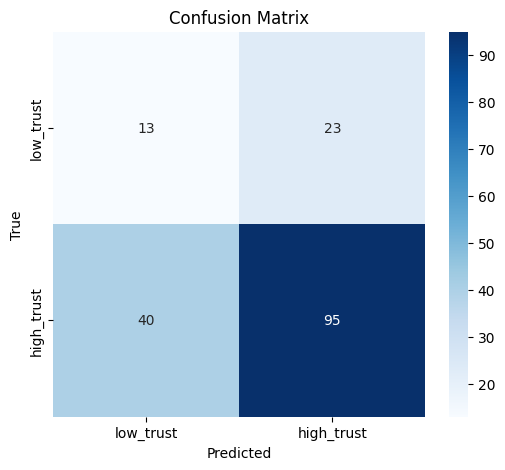

In [ ]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Nombres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1]  
y_true = y_test_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.680


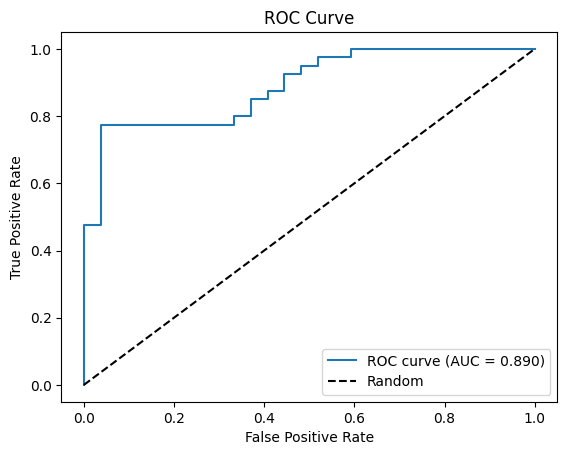

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [210]:
save_f1_history(
    clf=clf,
    architecture="EEGNeX",
    participant="P6"
)

Guardado en historial_f1_global.csv


## AttentionBaseNet

In [55]:
from braindecode.models import AttentionBaseNet


In [62]:
model = AttentionBaseNet(
    n_chans=19,
    n_outputs=2,
    n_times=256,
    drop_prob_inp=0.2,
    drop_prob_attn= 0.5,

)


In [63]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# criterion = FocalLoss(alpha=0.6, gamma=1.6)

In [64]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False)

early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=0.001,
    lower_is_better=True,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-2,
    optimizer__lr=1e-3,
    batch_size=64,
    callbacks=[ 
               f1_macro],
    max_epochs=30,
    device='cpu',
)


In [65]:
clf.fit(
    X_train_bal, 
    y_train_bal, 
)

# clf.fit(X_train_t, y_train_t)

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3193        0.6350       0.4691        0.6937  1.7856
      2      0.3193        0.5701       0.4691        0.7167  2.6262
      3      0.4214        0.5308       0.5062        0.7850  2.9500
      4      0.3732        0.5041       0.4259        0.8778  2.5828
      5      0.3602        0.4780       0.4074        0.9437  2.6630
      6      0.3849        0.4455       0.4136        0.9992  2.5940
      7      0.3408        0.4044       0.3519        1.0939  2.6424
      8      0.3866        0.3912       0.4012        1.0763  2.6395
      9      0.3606        0.3784       0.3704        1.1064  2.6176
     10      0.4016        0.3412       0.4074        1.1011  2.5986
     11      0.4334        0.3058       0.4383        1.1699  2.5794
     12      0.4249        0.2663       0.4259        1.2168  2.6057
     13      0.5242        0.2462 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  AttentionBaseNet (AttentionBaseNet)                          [1, 19, 256]              [1, 2]                    --                        --
  ├─_FeatureExtractor (input_block): 1-1                       [1, 19, 256]              [1, 40, 1, 13]            --                        --
  │    └─Ensure4d (ensure4d): 2-1                              [1, 19, 256]              [1, 19, 256, 1]           --                        --
  │    └─Rearrange (rearrange_input): 2-2                      [1, 19, 256, 1]           [1, 1, 19, 256]           --                        --
  │    └─Conv2d (temporal_conv): 2-3                           [1, 1, 19, 256]           [1, 40, 19, 256]          1,000                     [1, 25]
  │    └─BatchNorm2d (intermediate_bn): 2-4                    [1, 40, 19, 256]          [1, 40, 19, 256]          80                        --
  │    └─Conv2d (spatial_conv): 2-5                            [1, 40, 19, 256]          [1, 40, 1, 256]           760                       [19, 1]
  │    └─BatchNorm2d (bn): 2-6                                 [1, 40, 1, 256]           [1, 40, 1, 256]           80                        --
  │    └─ELU (nonlinearity): 2-7                               [1, 40, 1, 256]           [1, 40, 1, 256]           --                        --
  │    └─AvgPool2d (pool): 2-8                                 [1, 40, 1, 256]           [1, 40, 1, 13]            --                        [1, 75]
  │    └─Dropout (dropout): 2-9                                [1, 40, 1, 13]            [1, 40, 1, 13]            --                        --
  ├─Sequential (channel_expansion): 1-2                        [1, 40, 1, 13]            [1, 16, 1, 13]            --                        --
  │    └─Conv2d (0): 2-10                                      [1, 40, 1, 13]            [1, 16, 1, 13]            640                       [1, 1]
  │    └─BatchNorm2d (1): 2-11                                 [1, 16, 1, 13]            [1, 16, 1, 13]            32                        --
  │    └─ELU (2): 2-12                                         [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  ├─_ChannelAttentionBlock (channel_attention_block): 1-3      [1, 16, 1, 13]            [1, 16, 1, 1]             --                        --
  │    └─Sequential (conv): 2-13                               [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  │    │    └─Conv2d (0): 3-1                                  [1, 16, 1, 13]            [1, 16, 1, 13]            240                       [1, 15]
  │    │    └─Conv2d (1): 3-2                                  [1, 16, 1, 13]            [1, 16, 1, 13]            256                       [1, 1]
  │    │    └─BatchNorm2d (2): 3-3                             [1, 16, 1, 13]            [1, 16, 1, 13]            32                        --
  │    │    └─ELU (3): 3-4                                     [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  │    └─AvgPool2d (pool): 2-14                                [1, 16, 1, 13]            [1, 16, 1, 1]             --                        [1, 8]
  │    └─Dropout (dropout): 2-15                               [1, 16, 1, 1]             [1, 16, 1, 1]             --                        --
  ├─Sequential (final_layer): 1-4                              [1, 16, 1, 1]             [1, 2]            

In [ ]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas 
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[28  8]
 [51 84]]
              precision    recall  f1-score   support

           0       0.35      0.78      0.49        36
           1       0.91      0.62      0.74       135

    accuracy                           0.65       171
   macro avg       0.63      0.70      0.61       171
weighted avg       0.80      0.65      0.69       171



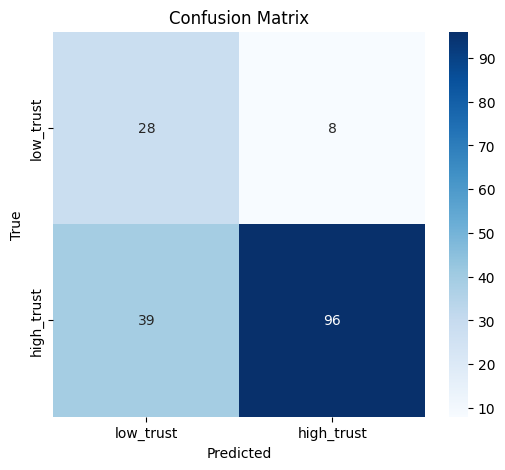

In [ ]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Nombres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1]  
y_true = y_test_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.680


In [223]:
save_f1_history(
    clf=clf,
    architecture="AttentionBaseNet",
    participant="P6"
)

Guardado en historial_f1_global.csv
